### Notebook for preprocessing and analyzing data from the sentence reading experiment  
Data from Wen, Snell & Grainger (2019). https://doi.org/10.1016/j.cognition.2019.04.013

In [95]:
from tqdm import tqdm
import mne
import numpy as np
import glob
import os
import pickle
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats 
import seaborn as sns
from mne.io import read_raw_bdf
from mne.preprocessing.ica import corrmap

#### Behavioral analysis (RTs & errors)

In [99]:
data_path = 'E:/Projects/2020_reading/SentenceReading/behavioural_data/'
behav_files=glob.glob(data_path+'/*.txt') # returns logfiles

df=pd.read_csv(behav_files[0], sep='\t', header=0)
correct_indices = np.where(df['correct']==1)
df.head(10)
#print(correct_indices)

,subject_nr,list,item_nr,order,cue,correct
0,2,2,114,2,3,0
1,2,2,151,2,4,1
2,2,2,170,2,4,1
3,2,2,28,1,1,0
4,2,2,165,2,4,1
5,2,2,140,1,3,1
6,2,2,12,2,1,1
7,2,2,68,2,2,0
8,2,2,136,1,3,1
9,2,2,22,2,1,1


In [98]:
err_data = df.groupby(['subject_nr', 'order', 'cue'], as_index=False)['correct'].mean()
err_data['condition'] = err_data['order'].map({1: 'normal', 2: 'scrambled'})
err_data['target_position']=err_data['cue']
#err_data['correct']=1-err_data['correct']

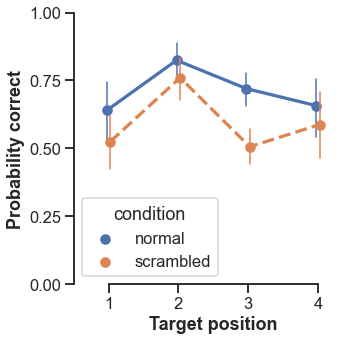

In [103]:
# Initialize the figure
f, ax = plt.subplots(figsize=(5,5))

# Show each observation with a scatterplot
# sns.stripplot(x="target_position", y="correct",  hue='condition',
#               data=err_data, dodge=False, jitter=True,
#               alpha=.4,#order=["1", "2", "3", "4"]
#              )

# Show the conditional means
sns.pointplot(x="target_position", y="correct", hue='condition',
              data=err_data,ci=95,dodge=.05, join=True,errwidth=1.5,
                scale=0.8,bw=.2, linestyles=['-', '--'],
             )


ax.set_yticks([0, 0.25,0.5,0.75, 1])
ax.set_xlabel("Target position",fontdict=dict(weight='bold'))
ax.set_ylabel("Probability correct",fontdict=dict(weight='bold'))

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

#### EEG plotting (files are preprocessed and averaged)

In [138]:
data_path = "E:/Projects/2020_reading/SentenceReading/EEG_data/"
EEG_files = glob.glob(data_path+'*scrambled.mat') # returns 23 EEG files
print('there are %i EEG files' %len(EEG_files))

there are 23 EEG files


#### merge data from both .mat files (scrambled + normal sentences) + put in correct format

In [139]:
from scipy.io import loadmat
excluded = [] #list of participants to exclude 
all_subj = []
df = pd.DataFrame()
df2 = pd.DataFrame()

for p in tqdm(range(0,len(EEG_files))): 
    print('Currently on ppn ', p)
    eeg_order=glob.glob(data_path+'ppn_'+str(p)+'_order.mat')
    eeg_scrambled = glob.glob(data_path+'ppn_'+str(p)+'_scrambled.mat')
    
    ## if required, ignore participants that are excluded 
    if p in excluded: 
        continue
        
    data_order = loadmat(eeg_order[0])['order_data']
    data_scrambled = loadmat(eeg_scrambled[0])['scrambled_data']

    df = pd.DataFrame(data_order)
    df['subj_idx'] = p
    df['channels'] = df.index
    df['condition'] = 'normal'
    df = df.melt(id_vars=['subj_idx', 'channels','condition'], var_name='timepoint')
    
    df2 = pd.DataFrame(data_scrambled)
    df2['subj_idx'] = p 
    df2['channels'] = df2.index
    df2['condition'] = 'scrambled'
    df2 = df2.melt(id_vars=['subj_idx', 'channels','condition'], var_name='timepoint')

    df = df.append(df2)
    all_subj.append(df)

data = pd.concat(all_subj)
data['time']=data['timepoint']*(900/922)-100    




  9%|███▋                                       | 2/23 [00:00<00:01, 16.02it/s]

Currently on ppn  0
Currently on ppn  1
Currently on ppn  2
Currently on ppn  3


 30%|█████████████                              | 7/23 [00:00<00:00, 17.60it/s]

Currently on ppn  4
Currently on ppn  5
Currently on ppn  6
Currently on ppn  7
Currently on ppn  8


 52%|█████████████████████▉                    | 12/23 [00:00<00:00, 18.96it/s]

Currently on ppn  9
Currently on ppn  10
Currently on ppn  11
Currently on ppn  12
Currently on ppn  13


 70%|█████████████████████████████▏            | 16/23 [00:00<00:00, 18.69it/s]

Currently on ppn  14
Currently on ppn  15
Currently on ppn  16
Currently on ppn  17
Currently on ppn  18


 91%|██████████████████████████████████████▎   | 21/23 [00:01<00:00, 18.66it/s]

Currently on ppn  19
Currently on ppn  20
Currently on ppn  21
Currently on ppn  22


100%|██████████████████████████████████████████| 23/23 [00:01<00:00, 18.99it/s]


#### make channel dictionary for easier plotting:

In [140]:
channel_dict = {1:"Fp1", 2:"AF7",3:"AF3",4:"F1",5:"F3",6:"F5",7:"F7",8:"FT7",9:"FC5",10:"FC3",11:"FC1",12:"C1",13:"C3",14:"C5",
                15:"T7",16:"TP7",17:"CP5",18:"CP3",19:"CP1", 20:"P1", 21:"P3",22:"P5",23:"P7",24:"P9",25:"PO7",26:"PO3",27:"O1",
                28:"Iz",29:"Oz",30:"POz",31:"Pz",32:"CPz",33:"Fpz",34:"Fp2",35:"AF8",36:"AF4",37:"AFz",38:"Fz",39:"F2",40:"F4",
                41:"F6",42:"F8",43:"FT8",44:"FC6",45:"FC4",46:"FC2",47:"FCz",48:"Cz",49:"C2",50:"C4",51:"C6",52:"T8",53:"TP8",
                54:"CP6",55:"CP4",56:"CP2",57:"P2",58:"P4", 59:"P6",60:"P8",61:"P10",62:"PO8",63:"PO4",64:"O2",65:"F9",66:"F10",
                67:"IO1",68:"IO2"} 
## needs to be reversed: 
chan_dict = {v: k for k, v in channel_dict.items()}

#### Select channels to plot: 

In [148]:
data2plot = data[data['channels'].isin([chan_dict["Cz"], chan_dict["Oz"]])]
#data2plot['value_flipped'] = data2plot['value'].mul(-1)
data2plot['channel_id'] = data2plot['channels'].replace(channel_dict)

C:\Users\noors\anaconda3\envs\OB1-EEG\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


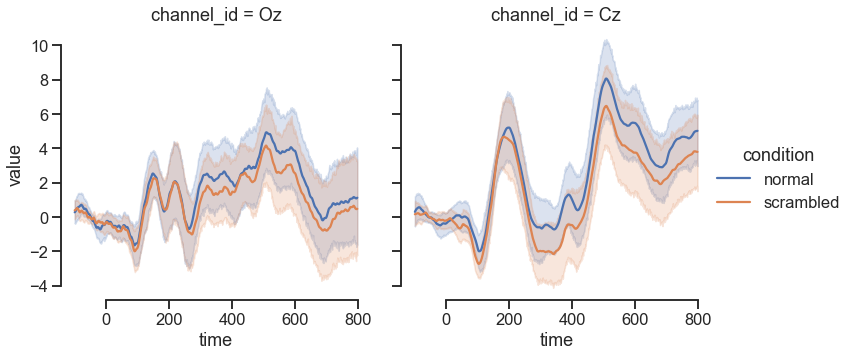

In [149]:
# Plot the responses for different events and regions
sns.relplot(x="time", y="value",ci=95,
             hue="condition",col="channel_id",kind="line",# style="event",
             data=data2plot)

ax.set_yticks([0, 0.25,0.5,0.75, 1])
sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

#### Or plot separately

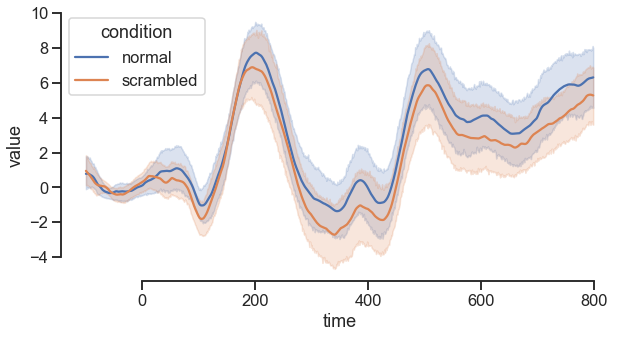

In [150]:
data2plot = data[data['channels']==chan_dict["Fz"]] ##channel Fz
#data2plot['value_flipped'] = data2plot['value'].mul(-1)

f, ax = plt.subplots(figsize=(10,5))
# Plot the responses for different events and regions
sns.lineplot(x="time", y="value",ci=95,
             hue="condition",# style="event",
             data=data2plot)

sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)

#### Our computational model of reading (OB1) reads in 25 ms timesteps. Therefore, downsample the data to 40 Hz: 

In [151]:
data.head(3)

,subj_idx,channels,condition,timepoint,value,time
0,0,0,normal,0,-0.543991,-100
1,0,1,normal,0,-1.776281,-100
2,0,2,normal,0,-0.433107,-100


In [152]:
from scipy.io import loadmat
from scipy.signal import resample

excluded = []
all_subj = []
df = pd.DataFrame()
df2 = pd.DataFrame()

for p in tqdm(range(0,len(EEG_files))): 
    print('Currently on ppn ', p)
    eeg_order=glob.glob(data_path+'ppn_'+str(p)+'_order.mat')
    eeg_scrambled = glob.glob(data_path+'ppn_'+str(p)+'_scrambled.mat')
    if p in excluded: 
        continue
        
    data_order = loadmat(eeg_order[0])['order_data']
    downsampled_order = resample(data_order, 36,axis=1)

    data_scrambled = loadmat(eeg_scrambled[0])['scrambled_data']
    downsampled_scrambled = resample(data_scrambled, 36,axis=1)
 
    df = pd.DataFrame(downsampled_order)
    df['subj_idx'] = p
    df['channels'] = df.index
    df['condition'] = 'normal'
    df = df.melt(id_vars=['subj_idx', 'channels','condition'], var_name='timepoint')
    
    df2 = pd.DataFrame(downsampled_scrambled)
    df2['subj_idx'] = p 
    df2['channels'] = df2.index
    df2['condition'] = 'scrambled'
    df2 = df2.melt(id_vars=['subj_idx', 'channels','condition'], var_name='timepoint')
    
    df = df.append(df2)
    all_subj.append(df)

data = pd.concat(all_subj)
data['time']=data['timepoint']*(900/36)-100    


 13%|█████▌                                     | 3/23 [00:00<00:00, 28.37it/s]

Currently on ppn  0
Currently on ppn  1
Currently on ppn  2
Currently on ppn  3
Currently on ppn  4
Currently on ppn  5
Currently on ppn  6


 48%|████████████████████                      | 11/23 [00:00<00:00, 32.26it/s]

Currently on ppn  7
Currently on ppn  8
Currently on ppn  9
Currently on ppn  10
Currently on ppn  11
Currently on ppn  12
Currently on ppn  13
Currently on ppn  14


 83%|██████████████████████████████████▋       | 19/23 [00:00<00:00, 34.90it/s]

Currently on ppn  15
Currently on ppn  16
Currently on ppn  17
Currently on ppn  18
Currently on ppn  19
Currently on ppn  20
Currently on ppn  21
Currently on ppn  22


100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 35.42it/s]


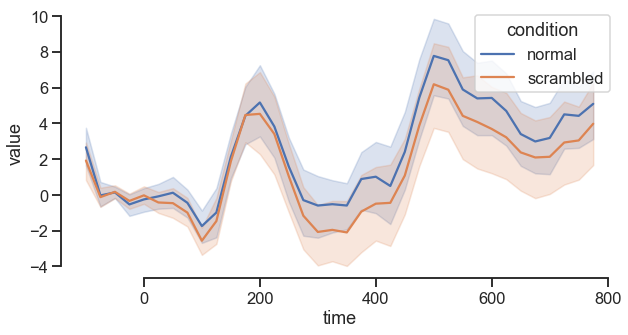

In [153]:
data2plot = data[data['channels']==chan_dict["Cz"]] ##channel Cz
#data2plot['value_flipped'] = data2plot['value'].mul(-1)

f, ax = plt.subplots(figsize=(10,5))
# Plot the responses for different events and regions
sns.lineplot(x="time", y="value",ci=95,
             hue="condition",# style="event",
             data=data2plot)

#ax.set_yticks([0, 0.25,0.5,0.75, 1])
sns.set(style="ticks")
sns.set_context('talk')
sns.color_palette("Paired")
sns.despine(offset=0, trim=True)